Twitter Sentiment Analysis
===============
This project is about analyzing tweets. We have a dataset with 1.6 million tweets at our disposal and they are labelled 0 (negative) or 4 (positive). <br> Our purpose is to exploit it in order to develop an algorithm for identifying the **sentiment polarity** in a tweet.

In [1]:
# Importing all the needed packages.

import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn

/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Data cleaning and preparation
Our first step will be to visualize our dataset in order to check whether it is "ready to use" or it needs to be adjusted before proceeding to build the model.

In [2]:
# Importing the dataset and giving it a look.

df = pd.read_csv("training.1600000.processed.noemoticon.csv", engine = "python", header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Adjusting the dataset according to our needs.

df = df.iloc[:, [0,5]]
df.columns = ["Sentiment", "Tweet"]
df["Sentiment"] = pd.to_numeric(df["Sentiment"])
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Removing some noise.

def cleaner(tweet):
    tweet = BeautifulSoup(tweet).get_text() # HTML tags
    tweet = re.sub(r'@\S+', '', tweet) # Mentions
    tweet = re.sub(r'http\S+', '', tweet) # Links
    for i in tweet.split():
        if i=="rt":
            tweet = re.sub(i, "", tweet) # Retweets
    tweet = re.sub("#", "", tweet) # Hashes
    tweet = tweet.lower() # Converting to lower case
    tweet = tweet.lstrip() # Initial and final spaces
    tweet = re.sub("\s\s+", " ", tweet) # Double spaces
    return tweet
df["Tweet"] = df["Tweet"].apply(lambda x: cleaner(x))

In [5]:
# Visualizing the shape of the dataset and checking if all the fields are properly filled.

print("There are " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns.")
nancount = df.isnull().sum().sum()
if nancount==0:
    print("Missing values found: 0. Every field is properly filled.")
else:
    print("Missing values found: " + str(nancount) + ". Deal with them before moving on.")

There are 1600000 rows and 2 columns.
Missing values found: 0. Every field is properly filled.


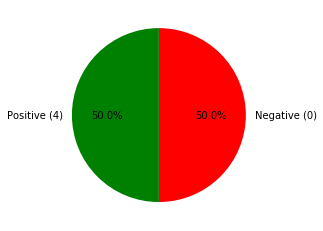

In [6]:
# Showing the percentage distribution of the labels.

labels = ["Negative (0)", "Positive (4)"]
negcount=0
poscount=0
for i in df.Sentiment:
    if i==0:
        negcount+=1
    elif i==4:
        poscount+=1
sizes = [poscount, negcount]
colors = ["red", "green"]
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=270)
plt.show()

## 2. Exploratory Data Analysis
The second step will be to perform an exploratory data analysis: we will analyze every single tweet by performing some NLP techniques such as PoS, NER etc.

NOTE: performing this kind of analysis on the whole dataframe would require significant amount of time. Therefore, for simplicity and given that we are not going to train the algorithms with the features from the analysis, we will analyze only the first 100 tweets (to analyze the whole dataset, it is enough to replace "0:100" with "100" as the first argument of the function ".iloc" when creating the dataframe called "EDA").

In [7]:
# Defining the SpaCy object and creating another dataframe for our analysis.

nlp = spacy.load("en_core_web_sm")
EDA = df.iloc[0:100, 1]
EDA = EDA.to_frame()

In [8]:
# Tokenization: breaking the stream of characters into words (tokens).

def tokenization(tweet):
    tweet = nlp(tweet)
    tok = []
    for i in tweet:
        tok.append(i.text)
    return tok
EDA["Tokenization"] = EDA["Tweet"].apply(lambda x: tokenization(x))

In [9]:
# Sentence Size: adding the length of the sentence (number of tokens).

def length(x):
    return len(x)
EDA["Sentence Size"] = EDA["Tokenization"].apply(lambda x: length(x))

In [10]:
# Stopwords: List of most common words of a language that are often useful to filter out.

def stopwords(tweet):
    stops = []
    for i in tweet:
        if nlp.vocab[i].is_stop:
            stops.append(i)
    return stops
EDA["Stopwords"] = EDA["Tokenization"].apply(lambda x: stopwords(x))

In [11]:
# PoS: marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its
# definition and its context.

def PoS(tweet):
    tweet = nlp(tweet)
    pos = []
    for i in tweet:
        pos.append([i.text, i.pos_])
    return pos
EDA["PoS"] = EDA["Tweet"].apply(lambda x: PoS(x))

In [12]:
# Dependency parsing: assigning a syntactic structure to the text.

def dependencyparsing(tweet):
    tweet = nlp(tweet)
    dep = []
    for i in tweet:
        dep.append([i.text, i.dep_])
    return dep
EDA["Dependency Parsing"] = EDA["Tweet"].apply(lambda x: dependencyparsing(x))

In [13]:
# NER (Named Entity Recognition): identifying token spans fitting a predetermined set of named entities.

def NER(tweet):
    tweet = nlp(tweet)
    ner = []
    if tweet.ents:
        for i in tweet.ents:
            ner.append([i.text, i.label_])
    else:
        ner.append("No named entities found.")
    return ner
EDA["NER"] = EDA["Tweet"].apply(lambda x: NER(x))

In [14]:
# Noun Chunks: Flat phrases that have a noun as their head.

def nounchunks(tweet):
    tweet = nlp(tweet)
    chunks = []
    for i in tweet.noun_chunks:
        chunks.append(i.text)
    return chunks
EDA["Noun Chunks"] = EDA["Tweet"].apply(lambda x: nounchunks(x))

In [15]:
# At the end, our dataframe built for Exploratory Data Analysis looks like this:

EDA.head()

,Tweet,Tokenization,Sentence Size,Stopwords,PoS,Dependency Parsing,NER,Noun Chunks
0,"- awww, that's a bummer. you shoulda got david...","[-, awww, ,, that, 's, a, bummer, ., you, shou...",22,"[that, 's, a, you, of, third, to, do, it]","[[-, PUNCT], [awww, PROPN], [,, PUNCT], [that,...","[[-, punct], [awww, advmod], [,, punct], [that...","[[shoulda, PERSON], [david carr, PERSON], [thi...","[a bummer, you, shoulda, david carr, third day..."
1,is upset that he can't update his facebook by ...,"[is, upset, that, he, ca, n't, update, his, fa...",25,"[is, that, he, ca, n't, his, by, it, and, migh...","[[is, AUX], [upset, ADJ], [that, SCONJ], [he, ...","[[is, ROOT], [upset, acomp], [that, mark], [he...","[[today, DATE]]","[he, his facebook, it, a result school]"
2,i dived many times for the ball. managed to sa...,"[i, dived, many, times, for, the, ball, ., man...",19,"[i, many, for, the, to, the, go, out, of]","[[i, PRON], [dived, VERB], [many, ADJ], [times...","[[i, nsubj], [dived, ROOT], [many, amod], [tim...","[[50%, PERCENT]]","[i, the ball, 50%, the rest, bounds]"
3,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...",10,"[my, whole, and, its, on]","[[my, DET], [whole, ADJ], [body, NOUN], [feels...","[[my, poss], [whole, amod], [body, nsubj], [fe...",[No named entities found.],"[my whole body, fire]"
4,"no, it's not behaving at all. i'm mad. why am ...","[no, ,, it, 's, not, behaving, at, all, ., i, ...",28,"[no, it, 's, not, at, all, i, 'm, why, am, i, ...","[[no, INTJ], [,, PUNCT], [it, PRON], ['s, AUX]...","[[no, intj], [,, punct], [it, nsubj], ['s, aux...",[No named entities found.],"[it, i, i, i, you]"


In [16]:
# To visualize the analysis related to a specific tweet it is enough to retrieve the row of the tweet of interest
# in the EDA dataframe.
# Alternatively, for a word-by-word analysis, you can change the number inside the square brackets in the following
# code and then execute it.

for i in nlp(EDA.Tweet[2]):
    print(i.text, "Is this a stopword? " + str(i.is_stop), i.pos_, i.dep_, sep='\t')

i	Is this a stopword? True	PRON	nsubj
dived	Is this a stopword? False	VERB	ROOT
many	Is this a stopword? True	ADJ	amod
times	Is this a stopword? False	NOUN	npadvmod
for	Is this a stopword? True	ADP	prep
the	Is this a stopword? True	DET	det
ball	Is this a stopword? False	NOUN	pobj
.	Is this a stopword? False	PUNCT	punct
managed	Is this a stopword? False	VERB	ROOT
to	Is this a stopword? True	PART	aux
save	Is this a stopword? False	VERB	xcomp
50	Is this a stopword? False	NUM	nummod
%	Is this a stopword? False	NOUN	dobj
the	Is this a stopword? True	DET	det
rest	Is this a stopword? False	NOUN	nsubj
go	Is this a stopword? True	VERB	ROOT
out	Is this a stopword? True	SCONJ	prep
of	Is this a stopword? True	ADP	prep
bounds	Is this a stopword? False	NOUN	pobj


## 3. Machine Learning approach

We are now in the critical part: choosing the best Machine Learning algorithm for predicting the sentiment polarity of a tweet. <br> The first thing to know is that raw text cannot be passed into a ML algorithm, therefore, we will extract features from our text by applying the **vectorization** (that is, extracting features from the raw text in order to pass numerical features to the machine learning algorithm). <br> After that, it will be possible to train, test and compare all of the different algorithms.

The vectorization functions that we are going to use are Count Vectorizer and TF-IDF Vectorizer. <br>
The machine learning algorithms that we are going to train and test are: Support Vector Machine, Multinomial Naive Bayes and Multinomial Logistic Regression.

We will try every possible combination and in the end we will see which one performed better by looking at the **metrics**.

In [17]:
# Let's first modify our dataset one last time: lemmatization. It converts each token to its standard form.

lemmatizer = WordNetLemmatizer()
def lemmatization(tweet):
    tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split()])
    return tweet
df["Tweet"] = df["Tweet"].apply(lambda x: lemmatization(x))

In [18]:
# Creating another dataframe equal to the original one, but shuffled. Then dividing data into 80% training and
# 20% test.

X = df["Tweet"]
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Defining the pipelines (Vectorization -> Training).

cv_svc = Pipeline([('cv', CountVectorizer()),
                     ('clf', LinearSVC())])
cv_mnb = Pipeline([('cv', CountVectorizer()),
                     ('clf', MultinomialNB())])
cv_lr = Pipeline([('cv', CountVectorizer()),
                     ('clf', LogisticRegression())])
tfidf_svc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC())])
tfidf_mnb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])
tfidf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression())])

In [20]:
# Training the algorithms.

cv_svc.fit(X_train, y_train)
cv_mnb.fit(X_train, y_train)
cv_lr.fit(X_train, y_train)
tfidf_svc.fit(X_train, y_train)
tfidf_mnb.fit(X_train, y_train)
tfidf_lr.fit(X_train, y_train)

/Users/nevrocerasani/opt/anaconda3/envs/text_mining/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/nevrocerasani/opt/anaconda3/envs/text_mining/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/nevrocerasani/opt/anaconda3/envs/text_mining/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [21]:
# Testing the algorithms.

test_cv_svc = cv_svc.predict(X_test)
test_cv_mnb = cv_mnb.predict(X_test)
test_cv_lr = cv_lr.predict(X_test)
test_tfidf_svc = tfidf_svc.predict(X_test)
test_tfidf_mnb = tfidf_mnb.predict(X_test)
test_tfidf_lr = tfidf_lr.predict(X_test)

In [22]:
# Incorporating their accuracies inside the variables for simplicity.

acc_cv_svc = metrics.accuracy_score(y_test, test_cv_svc)
acc_cv_mnb = metrics.accuracy_score(y_test, test_cv_mnb)
acc_cv_lr = metrics.accuracy_score(y_test, test_cv_lr)
acc_tfidf_svc = metrics.accuracy_score(y_test, test_tfidf_svc)
acc_tfidf_mnb = metrics.accuracy_score(y_test, test_tfidf_mnb)
acc_tfidf_lr = metrics.accuracy_score(y_test, test_tfidf_lr)

In [23]:
# Creating a dataframe with all the accuracies to see which model performed better.

accuracy = [["Count Vectorizer", "Support Vector Machine", acc_cv_svc], ["Count Vectorizer", "Multinomial Naive Bayes", acc_cv_mnb], ["Count Vectorizer", "Multinomial Logistic Regression", acc_cv_lr],
           ["TF-IDF", "Support Vector Machine", acc_tfidf_svc], ["TF-IDF", "Multinomial Naive Bayes", acc_tfidf_mnb], ["TF-IDF", "Multinomial Logistic Regression", acc_tfidf_lr]]
accuracy_df = pd.DataFrame(accuracy, columns = ["Vectorization", "Algorithm", "Accuracy"])

In [24]:
accuracy_df

,Vectorization,Algorithm,Accuracy
0,Count Vectorizer,Support Vector Machine,0.788309
1,Count Vectorizer,Multinomial Naive Bayes,0.779987
2,Count Vectorizer,Multinomial Logistic Regression,0.794759
3,TF-IDF,Support Vector Machine,0.792244
4,TF-IDF,Multinomial Naive Bayes,0.773250
5,TF-IDF,Multinomial Logistic Regression,0.797600


Classification report: 

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    159494
           4       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



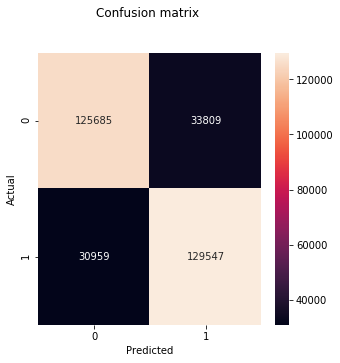

In [25]:
# It seems that the best performing algorithm is the Multinomial Logistic Regression, with the text vectorized by
# the TF-IDF technique: we reached an accuracy of 80%!
# Let's investigate it in further details by looking at the classification report and the confusion matrix.

print("Classification report: \n")
print(metrics.classification_report(y_test, test_tfidf_lr))
cm = metrics.confusion_matrix(y_test, test_tfidf_lr)
plt.figure(figsize=(5,5))
sn.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix \n \n")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

At the end of our sentiment analysis, we can conclude that all of the compared algorithms did a great job. They all reached more or less the same accuracy with minimum deviations, but the best performing one was the **Multinomial Logistic Regression** combined with the **TF-IDF** vectorization technique.
Our choice is justified by its 80% accuracy: in plain words it means that our algorithm is able to tell a positive tweet from a negative one 80 times out of 100.
More in detail: the total number of correctly classified tweets is 255.232 (125.685 + 129.547), while the total number of wrongly classified tweets is 64.768 (30.959 + 33.809).